# Multi-Disciplinary Design Optimization
## Abstract
This is a program for generating an optimized rocket design based on a feasible initial design, some fixed parameters, physical constants, and a theoretical rocket model. Mass is minimized while satisfying a number of mission constraints.

A feasible design is successfully produced and analyzed, as well as a model of it that is compatible with OpenRocket simulation. This provides a centralized source of authoritative information on the design of Portland State Aerospace Society's 4th launch vehicle design, LV4.

These programs were adapted by Cory and Aaron from the work done by Ondrej, Erin, and Ian on the original MDO.

This depends on several other programs, located in the same directory. They should be consulted, as they contain details which are omitted here.

* **System_Definition** 
    * contains all library imports,
    * defines some useful functions
    * defines all constants and parameters,
    * sets initial conditions and constraints, and
    * provides a single location to specify all the parts of a rocket design which are not explicitly optimized.
* **Structural Model**
    * Classes and function for making a structural model of the rocket which can be used by the trajectory model.
* **Natural_Environment_Model**
    * Class for managing coordinate conversions, gravity, atmosphere, and wind models.
* **Aerodynamics_Model**
    * Black magic, mostly imported from OpenRocket.
* **Trajectory_Simulation**
    * simulates a trajectory by numerical integration of equations of motion
* **openrocket_interface**
    * generates an OpenRocket model and its corresponding engine file for further testing, after conclusion of optimization.

## End-User Requirements
* A local copy of this repository
* Python3
* Jupyter Notebook
* SciPy
* NumPy
* pyHWM14
* nrlmsise00
* Matplotlib
* OpenRocket
    * This depends on Java 8 exactly (not later versions).
    * Technically unnecessary, but a file is created in the folder OpenRocket uses to store engine thrust curves.

## Standard Operating Procedure
0. RTFM.
1. Review assumptions of supporting notebooks.
2. Make appropriate modifications (if any) to parameters in **System_Definition** and set initial design variables there.
    * Note, garbage in, garbage out applies. If the initial design is infeasible, the optimization will abort.
3. Run all the code blocks in this notebook in sequential order.
4. Wait patiently for the algorithm to converge, perhaps a couple hours, depending on your computer.

## Motivation
The equations of motion for a rocket, a variable-mass system, are highly non-linear and there are no closed-form analytic solutions. Additionally, launch vehicles are complex systems with multiple interactions and mutual dependencies between their subsystems, each of which in and of itself constitute a difficult engineering project.

This presents a difficulty for clean-sheet design of a launch vehicle to fulfill specific mission requirements. A sufficiently detailed model and numerical integration techniques can be used to circumvent mathematical challenges to evaluating a given rocket design, at the cost of increased computational resources. A well-posed optimization problem and an algorithm implentating it can be used to capture constraints and requirements, to allow a feasible and locally optimal solution to emerge naturally from system dynamics.

There are other approaches to rocket design, such as trade space analysis or design of experiments. We have chosen our approach because it allows us to optimize the whole system all at once, hopefully cutting down on the time and effort that would be spent keeping the system consistent while developing only chunks of it at a time.

## Method
We may construct an *objective function* that represents the quality of our rocket as we see it. We selected Gross Liftoff Weight (**GLOW**) as our primary figure of merit, since it incorporates many aspects of a mission profile.

The Tsiolkovsky rocket equation $$\frac{\Delta v}{v_e} = \ln\left(\frac{m_0}{m_f}\right)$$ can be rearranged to isolate GLOW, $m_0$. The structure of the rocket and its subsystems determine its final dry mass, $m_f$; the effective exhaust velocity, $v_e$, captures engine performance; and the total change in velocity, $\delta v$, is determined by mission objectives, and can potentially include estimates of gravitational and atmospheric losses. So, minimizing GLOW while demanding a certain apogee is equivalent to simultaneously minimizing structural mass, maximizing engine performance, and balancing the conflicting goals of minimizing losses due to gravity and aerodynamics. Note that the sources of this conflict are the incentive to expel propellant rapidly to avoid the cost of carrying propellant in a gravitational field and the incentive to reduce velocity in lower atmosphere since drag is proportional to air pressure and the square of velocity.

In additional to this high-level objective, there are also several requirements and constraints that a given design must fulfill for a successful mission. These will be detailed in a following section. To represent them, we may use a series of *barrier* and *penalty functions* which bound potential rockets to a feasible region in the design space. A barrier function provides an absolute constraint that can not be violated under any circumstance, while a penalty function only disincentives designs if they stray far from a more permeable set of constraints.

By adding our three types of functions together, we obtain a *merit function* to minimize which encapsulates all of our relevant considerations as a positive real number. The input to our merit function is simply an array of values that are sufficient to determine our mathematical model of a rocket and its performance. However, each evaluation of the function entails that a simulation of the rocket's trajectory be computed, so the merit function itself does not admit to differentiation or finite differences.

There are several ways to approach this issue, two of which are covered in this program. If the design space is between 2 and 4 dimensions (inclusive), we may use the Nelder-Mead simplex method, a directed search that doesn't use derivatives. Note that a simplex is just a triangle generalized to n-dimensions. Performance of this geometry-based algorithm degrades as dimensionality increases, facilitating it becoming stuck in a local minimum. Another option is to use a genetic algorithm to seek a global optimum stochastically, which is much more computationally expensive but not restricted to low-dimensional spaces.

Theoretically, there are other methods possible, such as constructing and optimizing on a response surface model that is itself only a calculus-and-statistics-friendly model of our simulation model. We could also do Monte-Carlo simulation or some other stochastic optimization method, or even some sort of Latin Square trade-analysis. However, our results using both of the methods we selected closely agree and have been satisfactory.

Where we deviate significantly from [the previous MDO](https://github.com/psas/liquid-engine-analysis/blob/master/archive/LV4_Optimization.ipynb) is in our decision to do an iterative sequence of Nelder-Mead optimizations instead of just one. Before the penalty, and barrier functions are added to the objective function, they are weighed by user-selected parameters. Balancing these weights is an art; if they are too low, the optimizer can ignore or even abuse them, and if they are too high, the optimizer can neglect the objective and rapidly spiral into a somewhat artificial local minimum. Rather than picking arbitrary values that seem to give us the results we want, now we begin with very low weights, and for each successive optimization, we increase them.

This ought to enable more global coverage initially, while restricting the optimizer's freedom of movement in the design space after it has had a chance to find a satisfactory neighborhood. Since the weights become astronomically high, this also gives us a trivial method for determining whether we have articulated a well-posed problem and produced a strictly feasible design, or asked an unsatisfiable problem and received only the closest to being feasible design in a region of even worse alternatives.

Note that if a genetic algorithm is performed instead, an arbitrary weight must be selected intelligently, since a sequence of such optimization problems is exceedingly impractical.

We technically may not speak of "convergence", since it is possible for the Nelder-Mead method to stagnate on non-stationary points if the geometry of the simplex becomes ill-conditioned. However, since we are doing a sequence of optimizations, the simplex geometry is reset each time, so this is likely to not be an issue. The results have been in the same neighborhood as solutions given by a genetic algorithm, so our global coverage of the feasible region of the design space seems satisfactory.

## Assumptions
* If an optimization iteration returns a vector within $10^{-6}$ of the last iteration, there is no point in going further.
* Our initial design vector is already feasible (garbage in, garbage out).
* A 12" diameter is a reasonable stipulation.
    * If this is much wider, then drag becomes horrible, if this is much thinner, then the L/D ratio becomes unreasonable. The standing assumption was already that LV4 would be 12", so we made this a fixed parameter instead of a design variable, in part for conceptual simplicity for members of our organization.
    * Our optimization algorithm also performs poorly in high-dimensional spaces, so this should protect us from the curse of dimensionality. It is trivial to make it a design variable again, but we are moving forward as is.
* Our constraints are reasonable and satisfiable. 
* SciPy's implementations of the Nelder-Mead and genetic algorithm methods are sufficient for our purposes.

# Optimization Conditions

The objective of the optimization is to minimize Gross Lift-Off Weight (GLOW). Overall project costs are likely to scale with GLOW.

We distilled the key design variables to just propellant mass, mass flow rate, and exit pressure. All other relevant variables are determined from those and our design constants and parameters. For the sake of brevity, we won't go into those details in the following discussion, but the interested reader can learn more from the supporting notebooks.

Our optimization routine currently includes 7 inequality constraints:

* Apogee $h$: There are minimum and maximum acceptable altitudes of the trajectory.
* Thrust $F$: The electric feed system that pressurizes propellant prior to injection is not feasible for engines that are too powerful.
* Launch Speed $LS$: When the rocket leaves the launch rail it must be aerodynamically stable.
* Thrust-to-Weight Ratio $TWR$: Trade-off between gravity loss and aerodynamic stability.
* Length to Diameter Ratio $L/D$: Trade-off between aerodynamic stability and mechanical (non-rigid body) resonance modes.
* Maximum acceleration $\frac{a_{max}}{g_0}$: Set by the material limit loads of various launch vehicle subsystems.
* Nozzle over-expansion $\frac{p_e}{p_a}$: To ensure flow seperation.

Mathematically the problem can be stated as estimating $\bar{x}^*$ to a specified degree of precision according to these conditions,

$$ \lim_{n \to \infty} \mu_{n} = 0$$
$$ \lim_{n \to \infty} \rho_{n} = \infty$$
$$f_{n}(\bar{x}) = m_{obj}(\bar{x}) + \mu_{n}\sum_i h_i(\bar{x}) + \rho_{n}\sum_j g_j(\bar{x})$$
$$ \bar{x}_n = \min_{\bar{x}} f_{n}(\bar{x})$$
$$ \lim_{n \to \infty} \bar{x}_n = \bar{x}^{*},$$

\begin{eqnarray*} \mbox{where} \hspace{5 mm}
    \begin{split}\bar{x} = \left\{
        \begin{array}{ll}      & m_{prop}\\
          & \dot{m}\\
          & p_e \end{array}
        \right. \end{split}
    \hspace{2 mm} \mbox{, subject to} \hspace{2 mm}
    \begin{split}
        h_{barrier} = \left\{
        \begin{array}
            & 108401 m < h < 151401 \hspace{1 mm} m
            \end{array}
        \right. \end{split}
    \hspace{2 mm} \mbox{, and subject to} \hspace{2 mm}
    \begin{split}
          g_{penalty} = \left\{
          \begin{array}{ll}
              & F \leq 6 \hspace{1 mm} kN\\
              & LS \geq 22 \hspace{1 mm} m/s\\
              & \frac{a_{max}}{g_0} \leq 15 \hspace{1 mm} g's\\
              & TWR \geq 2\\
              & L/D \leq 21\\
              & \frac{p_e}{p_a} \geq 0.35\\
              \end{array}
          \right. \end{split}
    \end{eqnarray*}

It is possible that for any given $n$ or in the limit, there is not a unique global minimum. However, a local minimum is attained which is very close to the results of a genetic algorithm.

By sending the limit of $\mu$ to 0, the barrier function is relaxed, which allows designs to approach the absolute window for acceptable apogees. By sending the limit of $\rho$ to $\infty$, the penalty function is strengthened, which prevents designs from leaving the feasible region.

In [1]:
# Nelder-Mead simplex search
%matplotlib inline
%run OpenRocket_Interface.ipynb
%run Display_Information.ipynb
%run Fin_Staging.ipynb
#%run System_Definition.ipynb
#%run Trajectory_Simulation.ipynb

# i'm sorry for global vars...
global allvectors, dbz, allobjval
dbz = 0 # arithmetic error tracker (from crossing boundary constraints)
allvectors = []               # array for all design vecs, global variable
allobjfun = []                # array for tracking objective function evaluations

In [2]:
# Optimize engine thrust to < 6 kN, therefore set to ~ 5.5 kN as constraint is lenient
CONS_THRUST = 5599.67

## Functions of Merit
We chose to abstract all of the functions used within the merit function for increased flexibility, ease of reading, and later utility.

* **objective** is arbitrarily constructed. It is
    * normalized (by a somewhat arbitrary constant) to bring it into the same range as constraints,
    * squared to reward (or punish) relative to the distance from nominal value, and
    * divided by two so that our nominal value is 0.5 instead of 1.0.
* **exact** is less arbitrarily constructed. It is
    * squared to be horizontally symmetric (which could also be obtained by absolute value),
    * determined by the distance from a constant, and
    * divided by two is for aesthetic value.
* **exterior** is not particularly arbitrary. It is
    * boolean so that we can specify whether it is minimizing or maximizing its variable,
    * 0 when the inequality is satisfied, otherwise it is just as punishing as **exact**.
* **barrier** comes in two flavors, one of which is not used here. It is
    * boolean so that we can specify whether it is a lower or an upper bound,
    * completely inviolable, unlike exact and exterior penalties.
    
Technically logarithmic barrier functions allow negative penalties (i.e. rewards), but since we use upper and lower altitude barriers, it is impossible that their sum be less than 0. If the optimizer steps outside of the apogee window, the barrier functions can attempt undefined operations (specifically, taking the logarithm of a negative number), so some error handling is required to return an infinite value in those cases. Provided that the initial design is within the feasible region, the optimizer will not become disoriented by infinite values.

In [3]:
# all of our comparisons are ratios instead of subtractions because
# it's normalized, instead of dependent on magnitudes of variables and constraints

# minimize this, **2 makes it well behaved w.r.t. when var=cons
def objective(var, cons):
    return (var/cons)**2 / 2

def objective_additive(var, cons):
    return np.linalg.norm(var - cons)**2 / 2

# **2 because i like it more than abs(), but that also works
def exact(var, cons):
    return (var/cons - 1)**2 / 2

# this is your basic exterior penalty, either punishes for unfeasibility or is inactive
def exterior(var, cons, good_if_less_than=False):
    if good_if_less_than:
        return np.max([0, var/cons - 1])**2 / 2
    else:
        return np.max([0, -(var/cons - 1)])**2 / 2

# this barrier function restricts our objective function to the strictly feasible region
# make rockets great again, build that wall, etc, watch out for undefined operations
def barrier(var, cons, int_point=False, good_if_less_than=True):
    global dbz
    try: # just in case we accidentally leave feasible region
        if not int_point:
            if good_if_less_than:
                return -log(-(var/cons - 1))
            else:
                return -log(var/cons - 1)
        elif int_point:
            def interior(g): return 1/g # in case we don't like logarithms, which is a mistake
            if good_if_less_than:
                return -interior(var/cons - 1)
            else:
                return -interior(-(var/cons - 1))
    except:
        dbz += 1 # keep track of arithmetic errors, side effect
        return float('inf') # ordinarily, this is bad practice since it could confuse the optimizer
                            # however, since this is a barrier function not an ordinary penalty, i think it's fine

## Optimization Problem
Given a design vector $x$ and the iteration number $n$ our merit function **f** runs a trajectory simulation and evaluates the quality of that rocket. We keep track of each design and its merit value for later visualization, hence why global variables are used.

We run an iterative sequence of optimization routines for the win. We use the Euclidean distance in the design space between successive optimal designs to decide when it is no longer worth continuing, around the 6th decimal place.

In [4]:
# this manages all our constraints
# penalty parameters: mu -> 0 and rho -> infinity 
def penalty(sim, mu, rho):
    # barrier penalties have "less smooth" behavior
    b = [#barrier(#sim.alt[-1], CONS_ALT, int_point=False, good_if_less_than=False),
         #barrier(#sim.alt[-1], CONS_CEILING, int_point=False, good_if_less_than=True),
         #-log(sim.LV4.ballast),
         #barrier(sim.min_fin_flutter, 1.0, int_point=False, good_if_less_than=False)
        ]
    eq = []
    ext = [exterior(sim.alt[-1], CONS_ALT, good_if_less_than=False),
           exterior(sim.alt[-1], CONS_CEILING, good_if_less_than=True),
           #exterior(sim.min_fin_flutter, 1.0, good_if_less_than=False),
           exterior(sim.thrust[0], CONS_THRUST, good_if_less_than=True),
           exterior(sim.LV4.v_lfets_o, CONS_V_LFETS, good_if_less_than=True),
           exterior(sim.LV4.v_lfets_f, CONS_V_LFETS, good_if_less_than=True),
           #EFS removed
           #exterior(sim.LV4.pow_o, CONS_EFS, good_if_less_than=True),
           #exterior(sim.LV4.pow_f, CONS_EFS, good_if_less_than=True),
           # these dynamic constraints are reflective of the statistical correlation
           # between power and speed of motors commercially available. R^2 = 0.87, which is approximately 1.
           exterior(sim.LV4.rpm_o, 101003 - 6.96 * sim.LV4.pow_o, good_if_less_than=True),
           exterior(sim.LV4.rpm_f, 101003 - 6.96 * sim.LV4.pow_f, good_if_less_than=True),
           #exterior(sim.tip_off_aoa, CONS_AOA, good_if_less_than=True),
           #exterior(sim.launch_speed, CONS_LS, good_if_less_than=False),
           #exterior(sim.ld_ratio, CONS_LD, good_if_less_than=True),
           exterior(sim.TWR, CONS_TWR, good_if_less_than=False),
           exterior(sim.S_crit, CONS_S_CRIT, good_if_less_than=False),
           exterior(sim.max_g_force, CONS_ACCEL, good_if_less_than=True),
           #exterior(sim.min_stability, CONS_STBLTY, good_if_less_than=False),
           exterior(sim.impulse, CONS_IMPLS, good_if_less_than=True),
           exterior(sim.LV4.lox_tank.p_0, sim.LV4.TANK_MAX_P, good_if_less_than=True),
           exterior(sim.LV4.ipa_tank.p_0, sim.LV4.TANK_MAX_P, good_if_less_than=True),
           exterior(sim.LV4.lox_tank.p_0, CONS_TANK_MIN, good_if_less_than=False),
           exterior(sim.LV4.ipa_tank.p_0, CONS_TANK_MIN, good_if_less_than=False)
          ]
    return mu*sum(b) + rho*(sum(eq) + sum(ext))

# Pseudo-objective merit function
# x is array of design parameters, n is index of penalty and barrier functions
# print blocks are sanity checks so i'm not staring at a blank screen and can see what various tweaks actually do
def f(x, n=8):
    global allvectors, allobjfun
    ipa_wt, of_ratio, p_ch, Tc, MW, gamma, _ = propellant_optimizer(x[5])
    # get trajectory data
    sim = trajectory(False, 0, 0, 0, 0, 0, 0, 0, x[0], x[1], x[2],
               THROTTLE_WINDOW, MIN_THROTTLE,
               RCS_MDOT, RCS_P_E, RCS_P_CH,
               BALLAST, FIN_ROOT, FIN_TIP, FIN_SWEEP_ANGLE, FIN_SEMISPAN, FIN_THICKNESS, CON_NOSE_L,
                x[3], x[4], RIB_T, NUM_RADL_DVSNS,
               AIRFRM_IN_RAD, ipa_wt, of_ratio, x[5], Tc, gamma, MW,
               [0, 0, AZ_PERTURB, EL_PERTURB, True, 0, 0, 0, 0, 0, 0, True], 
                0.025, True, 0.005, False, False)
    
    obj_func = (1 * objective(sim.LV4.GLOW, CONS_MASS))
                # + 0.4 * (np.linalg.norm(sim.thrust[sim.F_index])/8000)**10)
                # base 11 constraint + 0.1 * objective(x[0]/x[1], 40)) # minimize GLOW
    # then, calculate penalization from trajectory performance
    pen_func = penalty(sim, MU_0 / (2**n), RHO_0 * (2**n)) # initial mu and rho selected for nice behavior
    # add objective and penalty functions
    merit_func = obj_func + pen_func
    if np.isnan(merit_func): merit_func = np.inf # crude hack
    allvectors.append(x) # maintains a list of every design, side effect
    allobjfun.append(log(merit_func)) # log plot is cleaner to look at, for later
    return merit_func

# we want to iterate our optimizer for theoretical "convergence" reasons (given some assumptions)
# n = number of sequential iterations
def iterate(f, x_0, n):
    x = x_0 # initial design vector
    global dbz
    designs = []
    for i in range(n):
        print("Iteration " + str(i+1) + ":")
        res = minimize(f, x, args=(i+3), method='nelder-mead', options={'disp': True, 'adaptive':True, 'xatol': 1, 'fatol': 0.1})
        x = res.x # feed optimal design vec into next iteration
        
        designs.append(res.x)   # we want to compare sequential objectives 
                                # so we can stop when convergence criteria met
        alt = trajectory(fin_staging, stage_drop_ECEF, stage_root, stage_tip, stage_sweep, stage_span, stage_thickness, mass_red, x[0], x[1], x[2],
               THROTTLE_WINDOW, MIN_THROTTLE,
               RCS_MDOT, RCS_P_E, RCS_P_CH,
               BALLAST, FIN_ROOT, FIN_TIP, FIN_SWEEP_ANGLE, FIN_SEMISPAN, FIN_THICKNESS, CON_NOSE_L,
                x[3], x[4], RIB_T, NUM_RADL_DVSNS,
               AIRFRM_IN_RAD, IPA_WT, OF, ENG_P_CH, ENG_T_CH, ENG_KE, ENG_MM,
               [0, 0, AZ_PERTURB, EL_PERTURB, True, 0, 0, 0, 0, 0, 0, True], 
                          0.025, True, 0.005, False, False).alt
        
        print("         Arithmetic errors (from violations of acceptable altitude window): "+str(dbz))
        print("Propellant mass (kg): "+str(x[0]))
        print("Mass flow rate (kg/s): "+str(x[1]))
        print("Exit pressure (Pa): "+str(x[2]))
        print("Peak Altitude (km): "+str(alt[-1]/1000))
        print('')
        dbz=0 # I only care about divisions by zero in each individual iteration, side effect
        if (i > 0) and (np.linalg.norm(designs[-1] - designs[-2]) < DELTA):
            print("Early termination! The Euclidean distance between the last two designs was < " + str(DELTA))
            break
    return x

def breed_rockets(f):
    res = differential_evolution(f, [(80, 200), (2.0, 4.5), (45000, 150000)],
                                 strategy='best1bin', popsize=80, mutation=(.1, .8), recombination=.05,
                                 updating='immediate', disp=True, atol=0.1, tol=0.1)
                                 #polish=True,workers=-1, disp=True, atol=0.1, tol=0.1)
    return res.x

def benchmark(x):
        return x[0]*x[1] - x[2]

## Optimization Information and Graphing
It is to the benefit of our intuition if we can visualize the design space and our final trajectory. This block of code simply provides all of the relevant information from a trajectory as text, and displays useful graphs.

# Top-Level of Optimization Routine
Here's where the magic happens. This code block runs the iterative optimization, provides details from our optimized trajectory, uses the OpenRocket interface to make a model rocket and engine for higher-fidelity analysis, and then displays visuals.

The optimization approaches are RBFOpt Global Optimization, Iterative Nelder-Mead, and Simplicial Homology Global Optimization combined with a local minimization method. RBFOpt produces results in ~ 2 hours depending on your machine. The two array arguments passed to the RbfoptUserBlackBox class define the bounds of the black box and correspond to minimum and maximum feasible values for the design vector. Iterative Nelder-Mead does take a while, however in the iterate function in the above code block you may change the 'xatol' and 'fatol' parameters to relax the termination condition. These correspond to the absolute error in the design vector and its merit function evaluation between iterations such that the optimization will terminate. Simplicial Homology is my preferred method as it finds approximations to local minima, and then performs local minimization at each of these to find the global minimum. This method is theoretically guaranteed to find the global minimum when using the 'simplicial' sampling method, and produces results in ~ 1 hour.

Fin Staging - the first 8 arguments of the trajectory function are:<br>
1) The boolean variable fin_staging, indicating whether or not you would like to simulate this<br>
2) stage_drop_ECEF, the ideal drop altitude is calculated given stability margin analysis<br>
3) stage_root, root chord of new fin<br>
4) stage_tip, tip chord "          "<br>
5) stage_sweep, sweep angle "      "<br>
6) stage_span, semispan "          "<br>
7) stage_thickness, thickness "    "<br>
8) mass_red, mass of initial larger fin can

Began optimization at 2022-07-06 15:31:35.617331
Splitting first generation
[-4.30931597e-04  2.45827575e-04  2.26849197e+00]
[-1.79293047e-04  1.02278819e-04  3.97710808e+00]
[-1.82984275e-04  1.04384503e-04  3.90699802e+00]
[-1.82984275e-04  1.04384503e-04  3.90699802e+00]
[-1.82984275e-04  1.04384503e-04  3.90699802e+00]
[-1.80898608e-04  1.03194722e-04  3.95395143e+00]
[-1.79106956e-04  1.02172663e-04  3.99402771e+00]
[-1.81023198e-04  1.03265795e-04  3.93858161e+00]
[-1.81096571e-04  1.03307651e-04  3.94945984e+00]
[-1.81343676e-04  1.03448613e-04  3.93126404e+00]
[-1.83155254e-04  1.04482039e-04  3.89080557e+00]
[-1.80898608e-04  1.03194722e-04  3.95395143e+00]
[-1.79106956e-04  1.02172663e-04  3.99402771e+00]
[-1.79293047e-04  1.02278819e-04  3.97710808e+00]
[-1.81023198e-04  1.03265795e-04  3.93858161e+00]
[-1.81096571e-04  1.03307651e-04  3.94945984e+00]
[-1.81343676e-04  1.03448613e-04  3.93126404e+00]
[-1.83155254e-04  1.04482039e-04  3.89080557e+00]
[-1.82984275e-04  1.0438

[-4.25434044e-04  2.42691462e-04  2.29160307e+00]
[-4.25804664e-04  2.42902885e-04  2.29058552e+00]
[-4.25611898e-04  2.42792920e-04  2.29111453e+00]
[-4.25609439e-04  2.42791517e-04  2.29112129e+00]
[-4.25639928e-04  2.42808910e-04  2.29103756e+00]
[-4.25594072e-04  2.42782751e-04  2.29116346e+00]
[-4.25604521e-04  2.42788712e-04  2.29113479e+00]
[-4.25588765e-04  2.42779724e-04  2.29117805e+00]
[-4.25560753e-04  2.42763744e-04  2.29125497e+00]
[-4.25593824e-04  2.42782610e-04  2.29116416e+00]
[-4.25610801e-04  2.42792294e-04  2.29111754e+00]
[-4.25592290e-04  2.42781734e-04  2.29116835e+00]
[-4.25590111e-04  2.42780491e-04  2.29117436e+00]
[-4.25602487e-04  2.42787552e-04  2.29114036e+00]
[-4.25598057e-04  2.42785025e-04  2.29115253e+00]
[-4.25592116e-04  2.42781635e-04  2.29116885e+00]
[-4.25591672e-04  2.42781382e-04  2.29117005e+00]
[-4.25598179e-04  2.42785094e-04  2.29115220e+00]
[-4.25593892e-04  2.42782648e-04  2.29116397e+00]
[-4.25594659e-04  2.42783086e-04  2.29116186e+00]


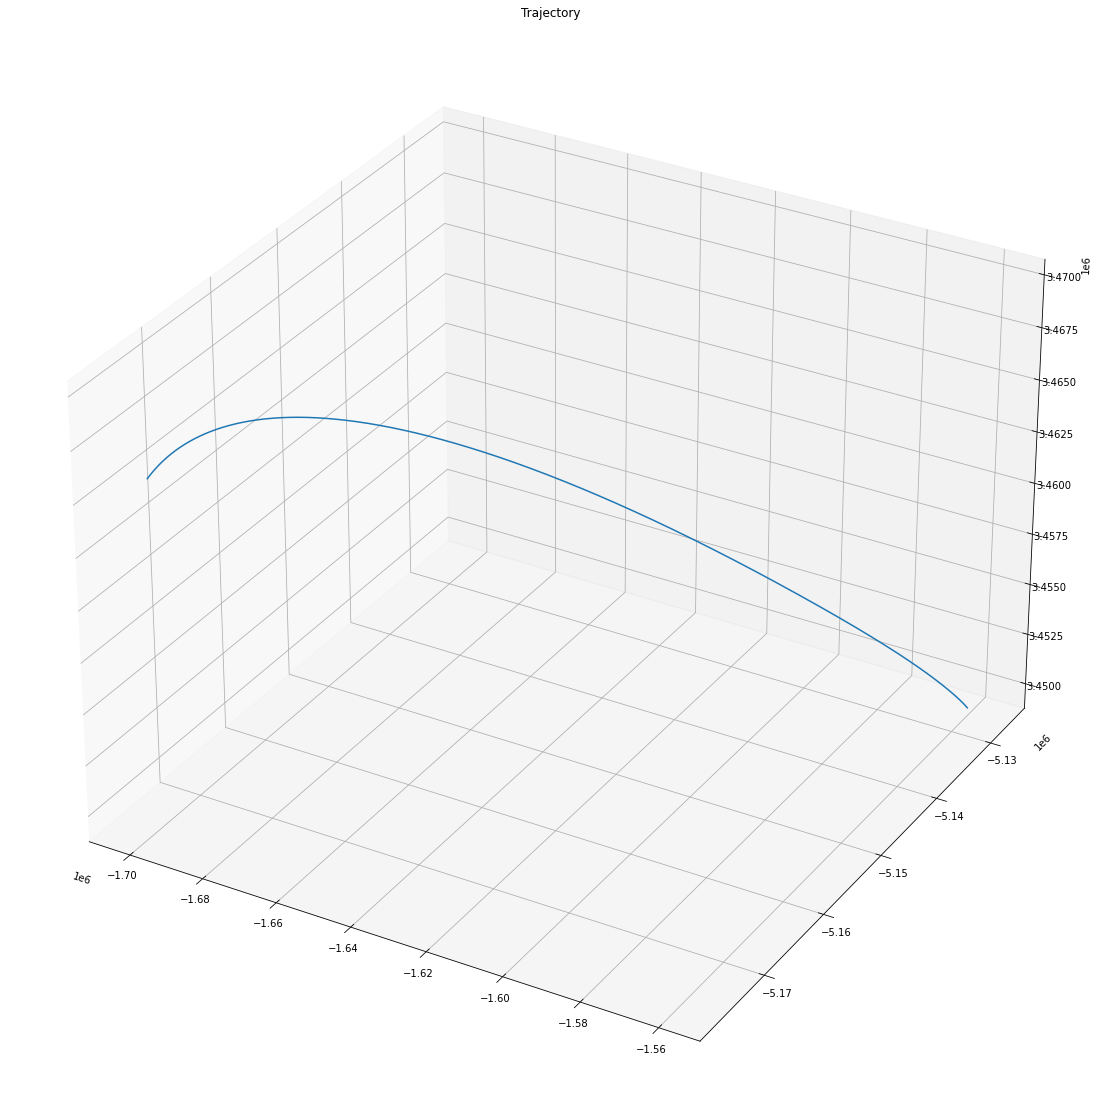

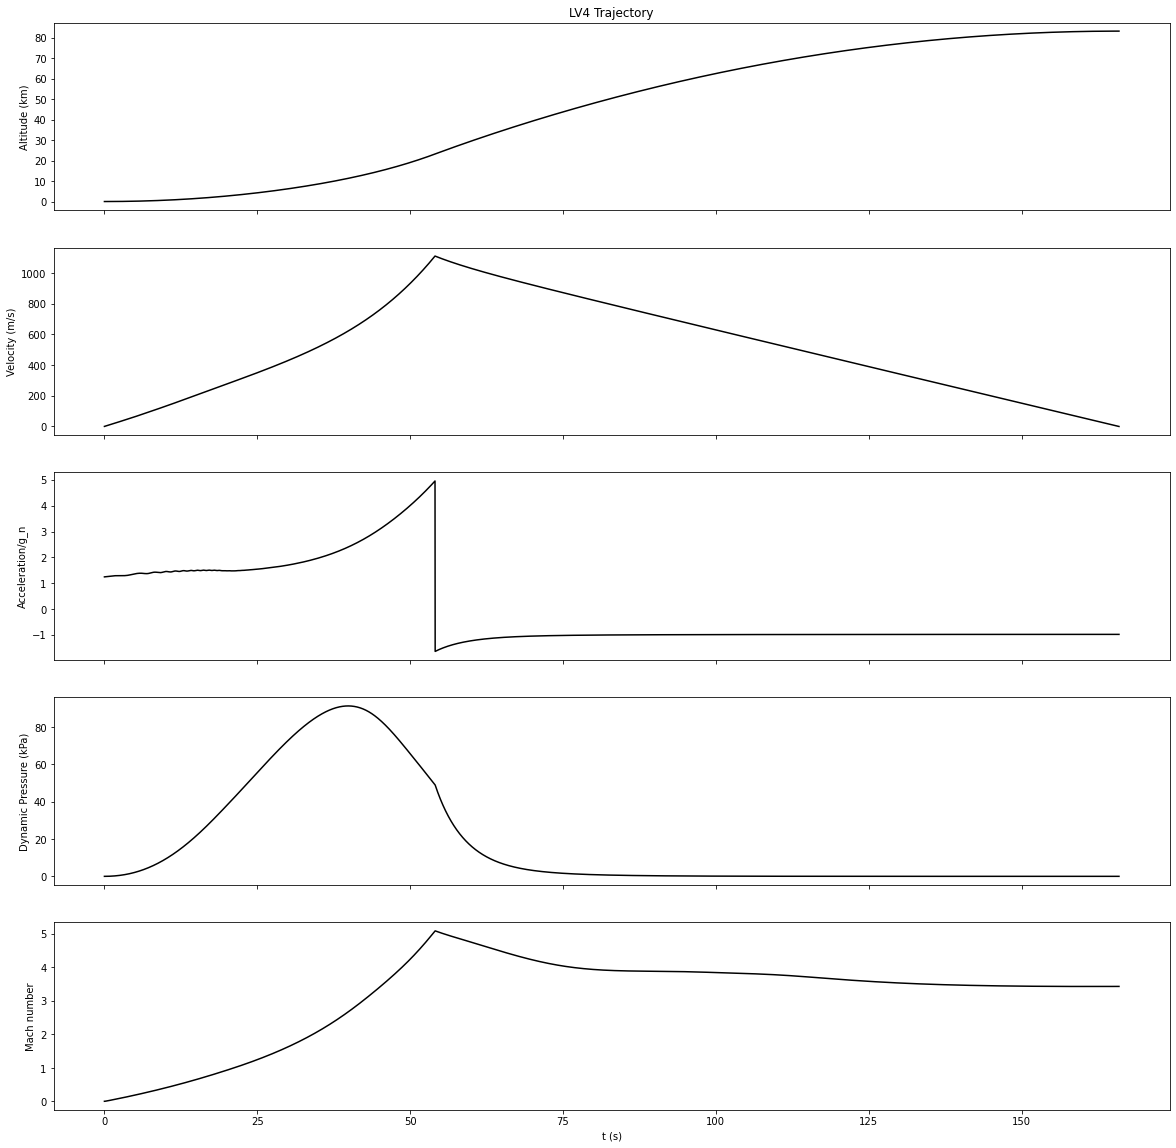

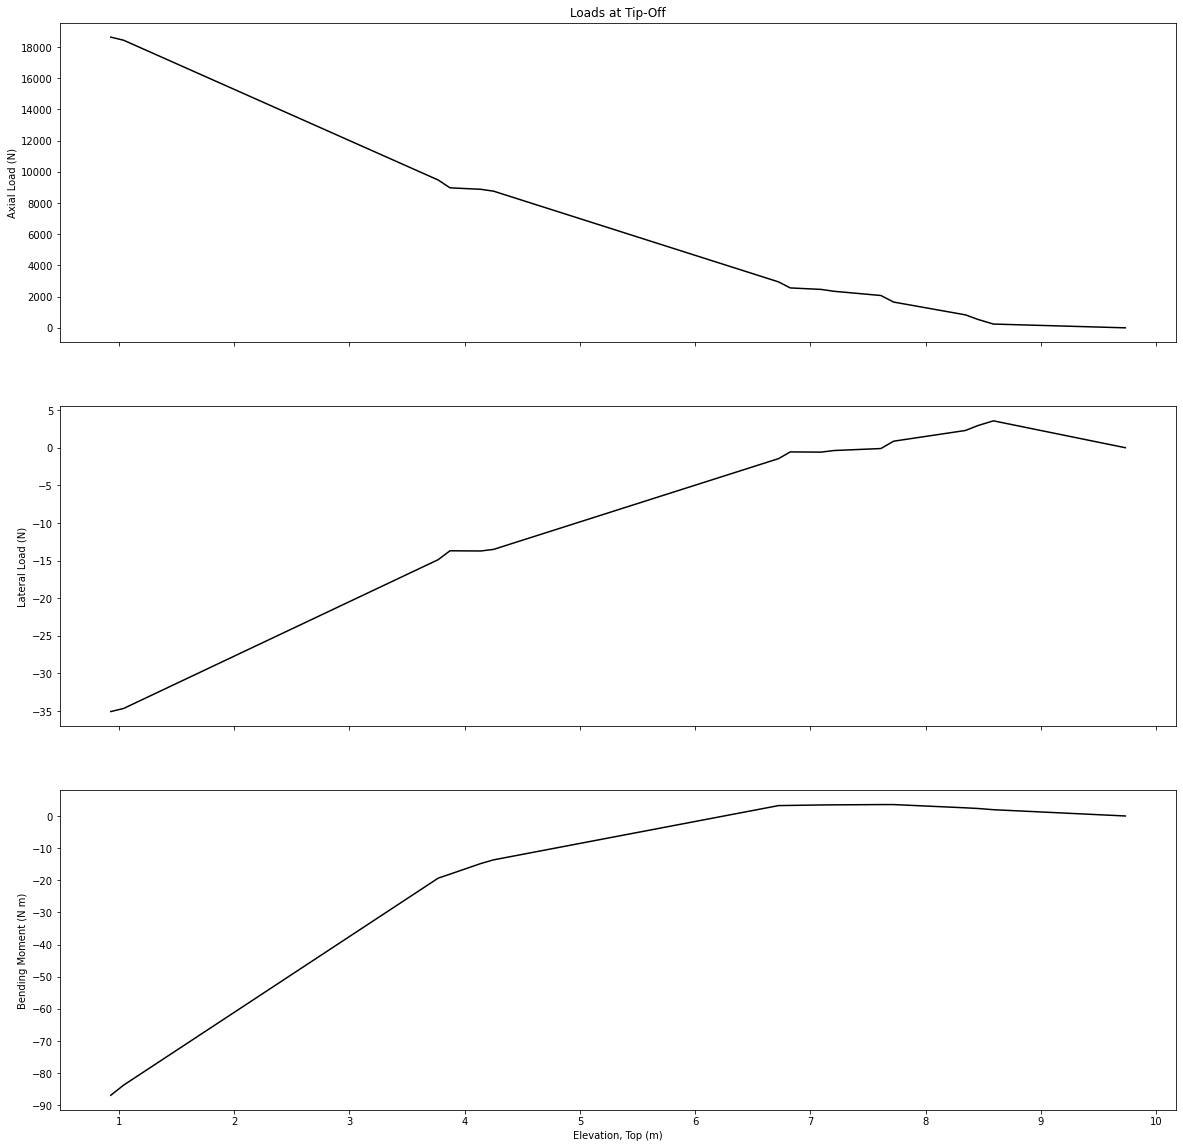

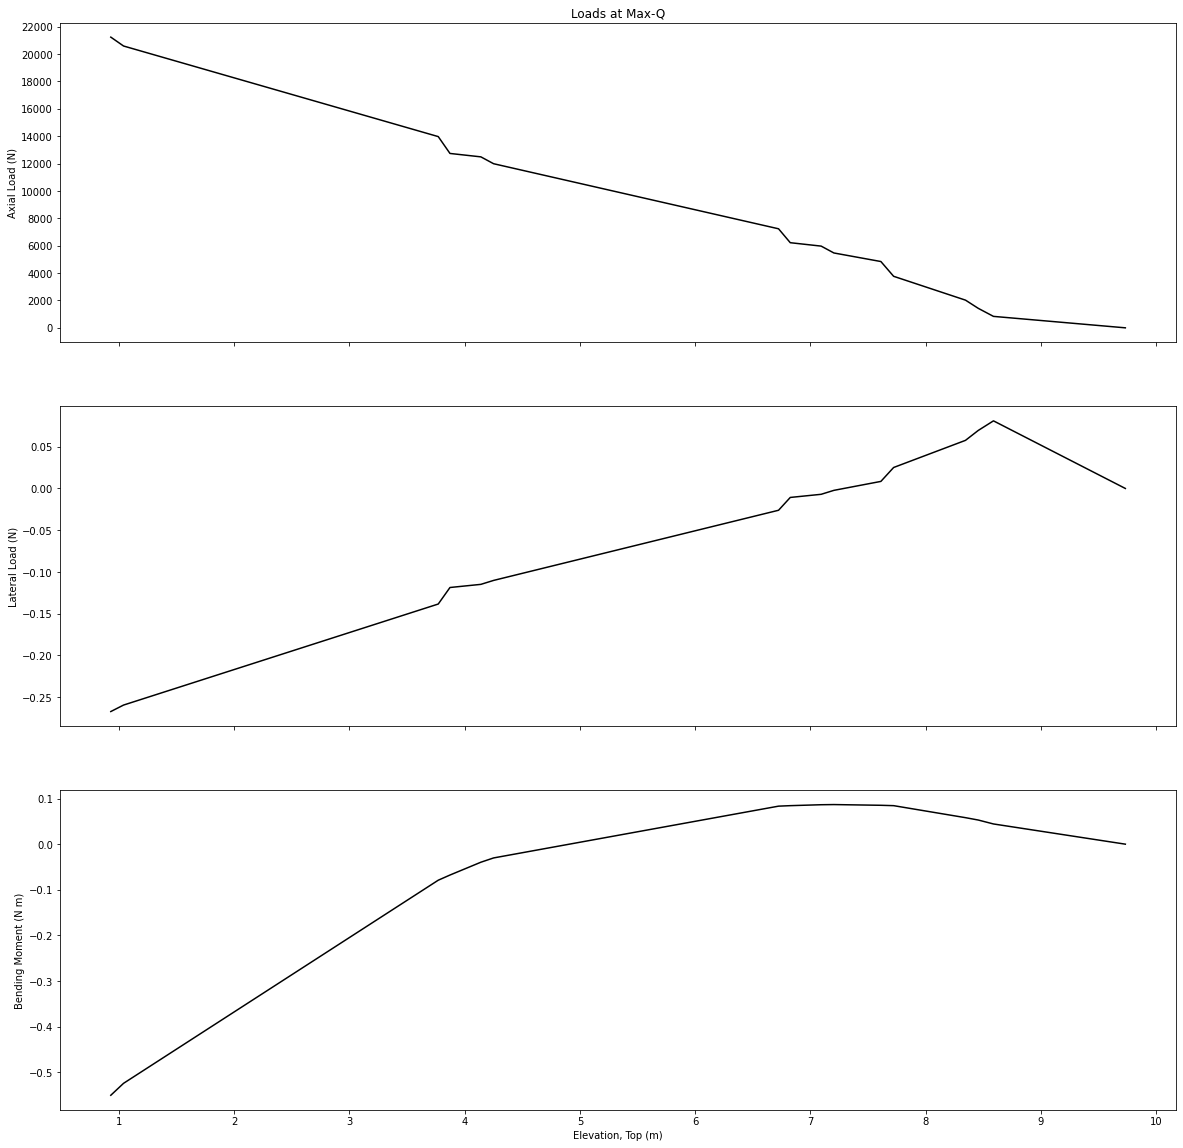

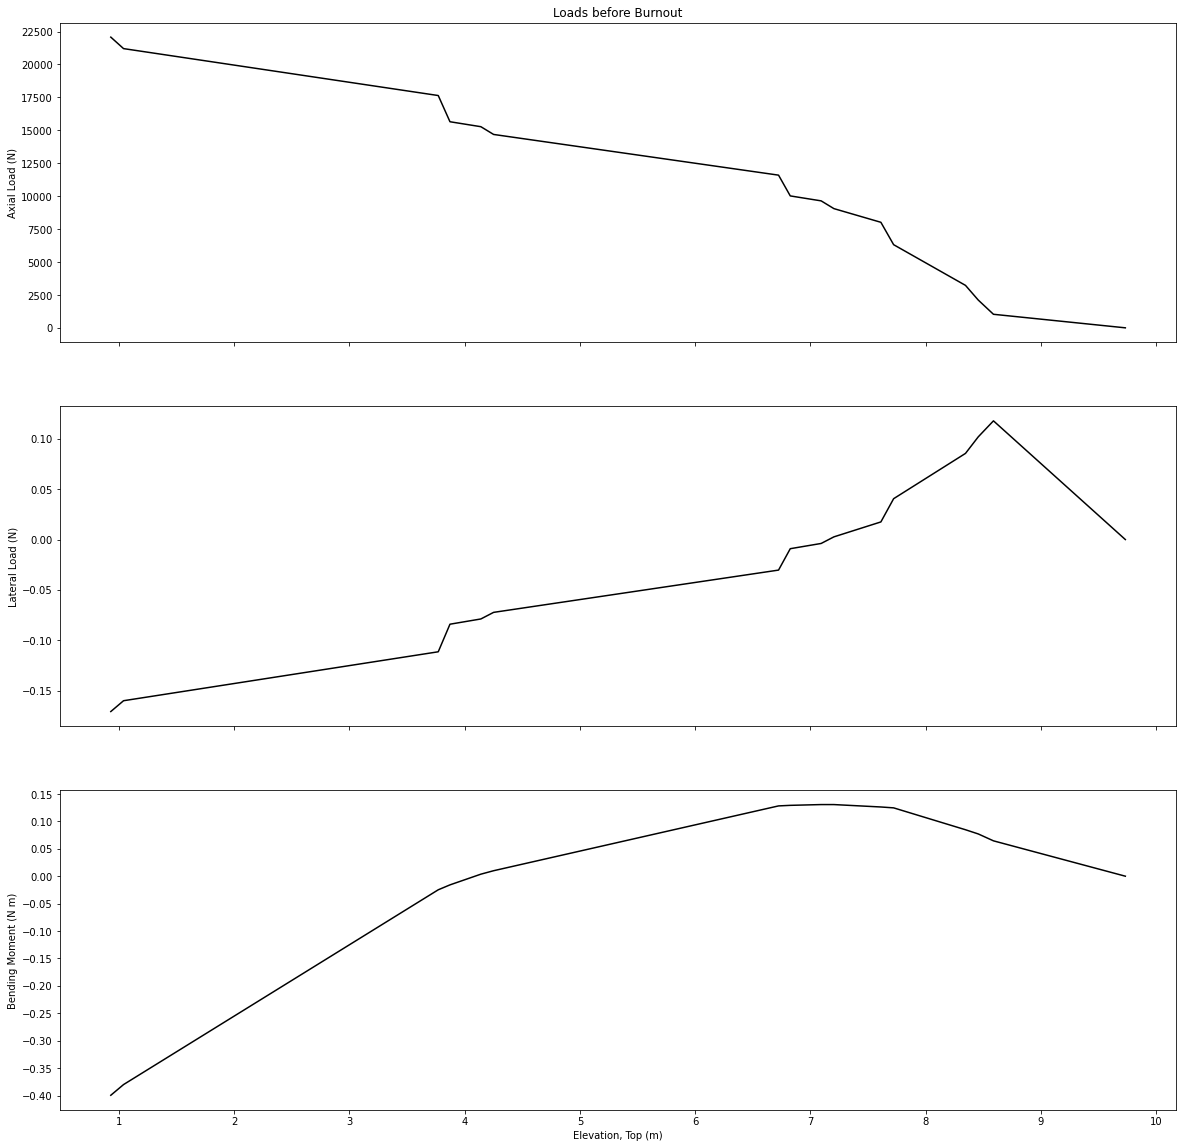

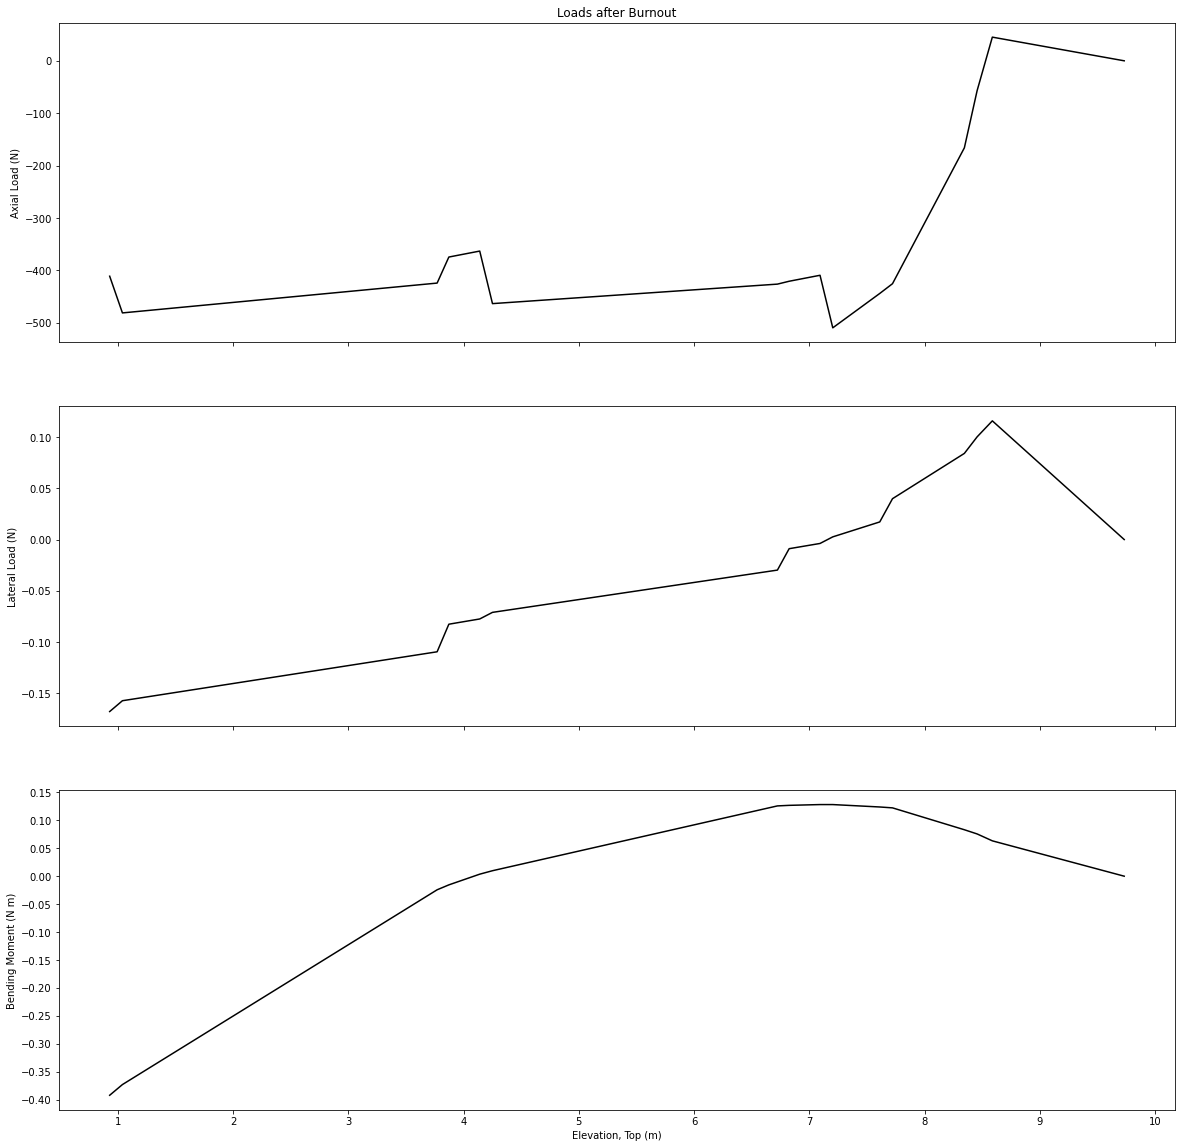

(32.63414359645966, -108.1948460108481, 84579.13430879643)
83301.55508444365
6.6106583785230955
6.6106583785230955
6/07/2022 16:56:48
DESIGN VECTOR
-----------------------------
design total propellant mass               = 306.2930 kg
design unadjusted propellant mass          = 299.7606 kg
design mass flow rate                      = 5.4331 kg/s
design nozzle exit pressure                = 57563.9918 Pa
total tankage length (after adjustment)    = 5.1676 m
design airframe diameter                   = 0.3048 m.
design airframe total length               = 9.7326 m.
design GLOW                                = 445.4683 kg
design ballast mass                        = 2.0000 kg
conical part of nosecone length            = 1.0923 m
design fin root chord                      = 0.7620 m
design fin tip chord                       = 0.3302 m
design fin sweep angle                     = 40.0000 deg
design fin span                            = 0.4064 m
design fin thickness                       

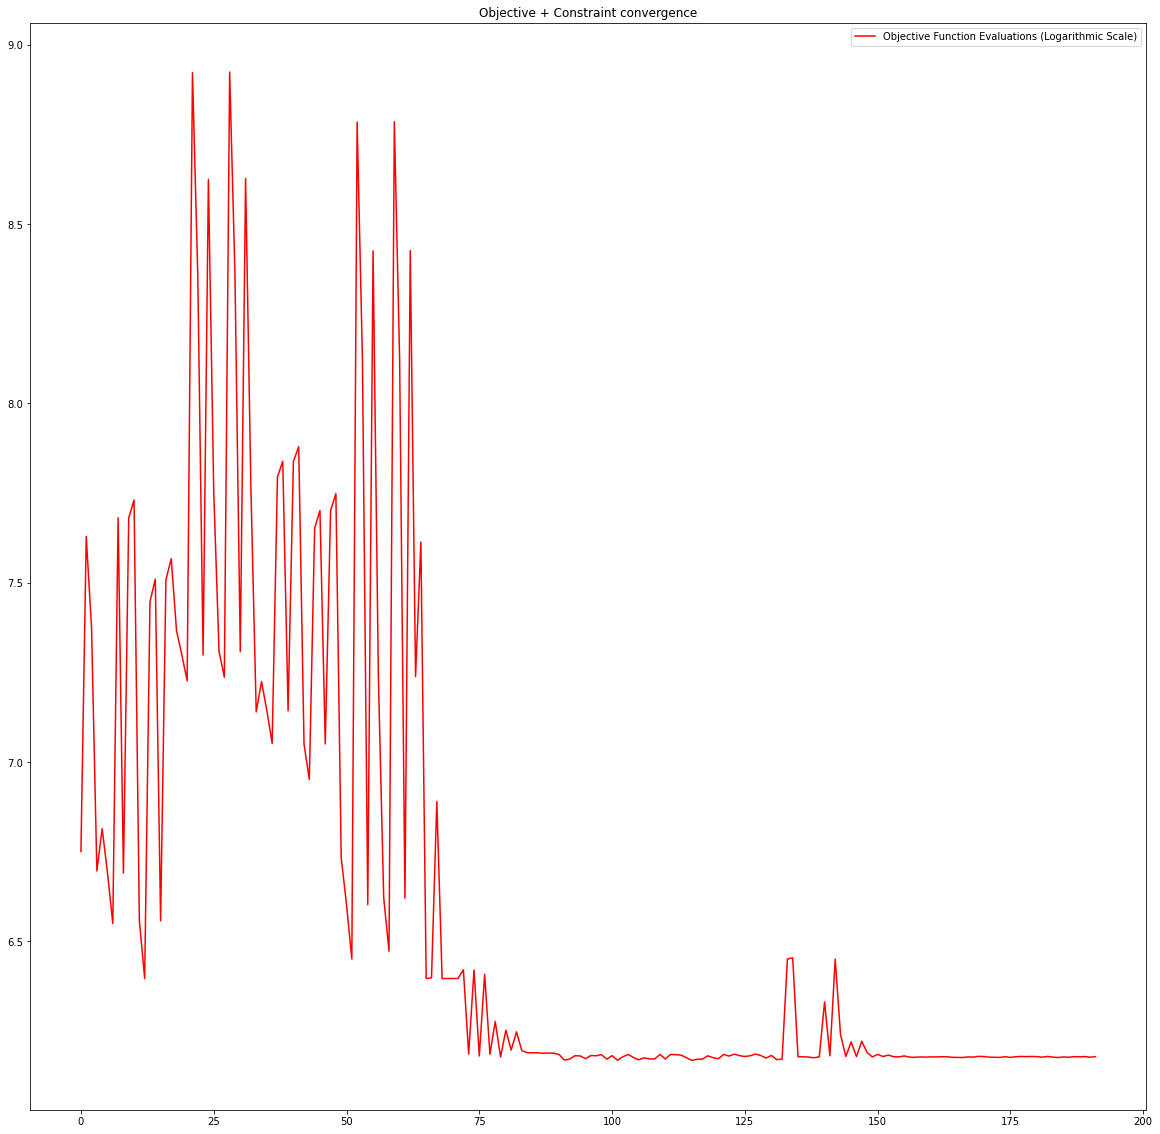

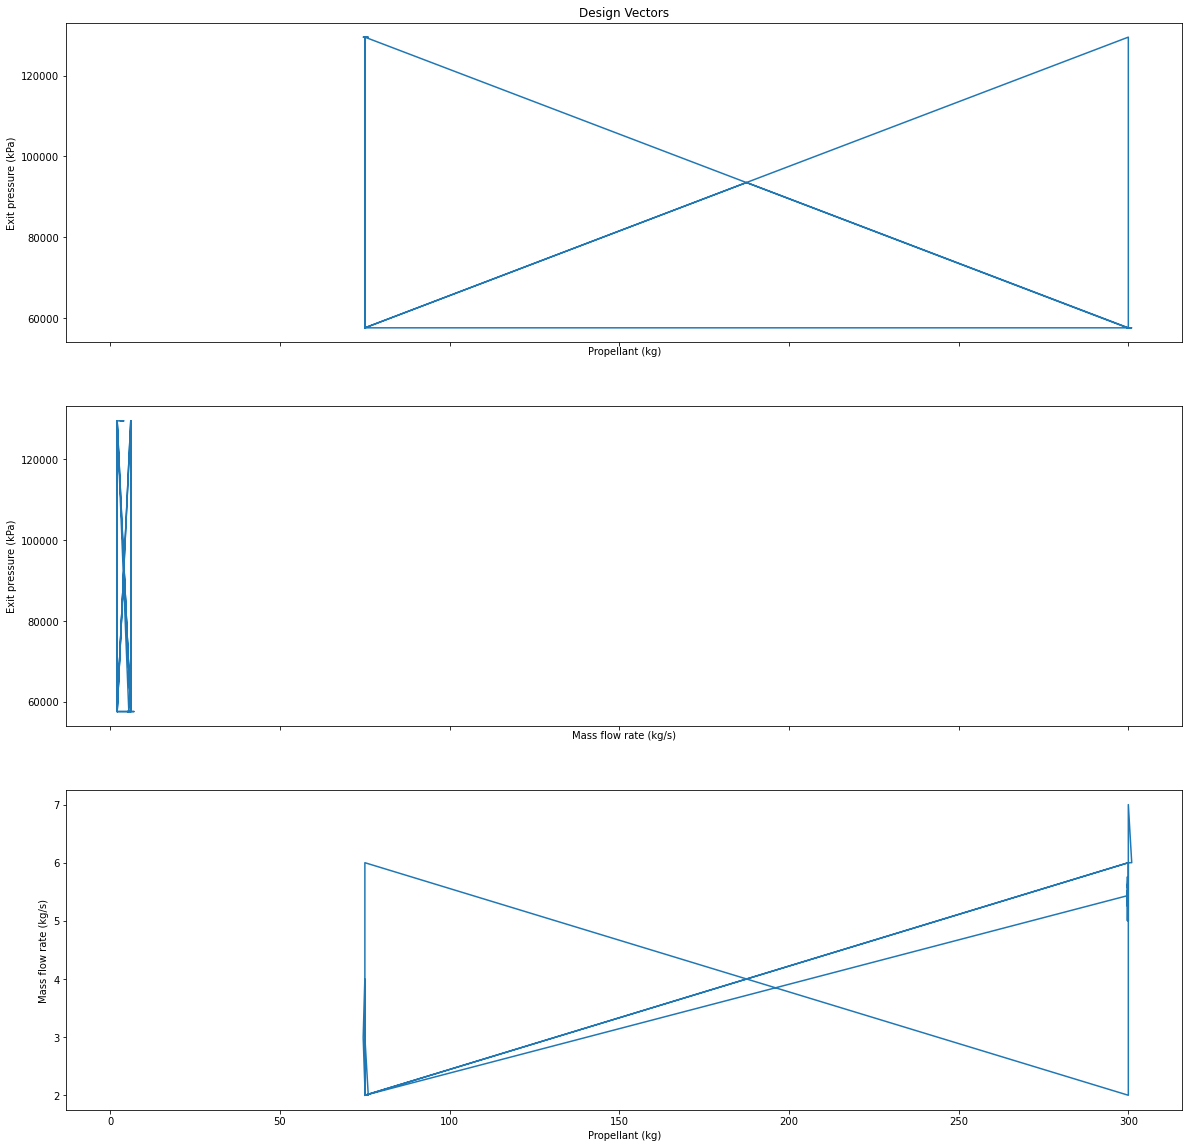

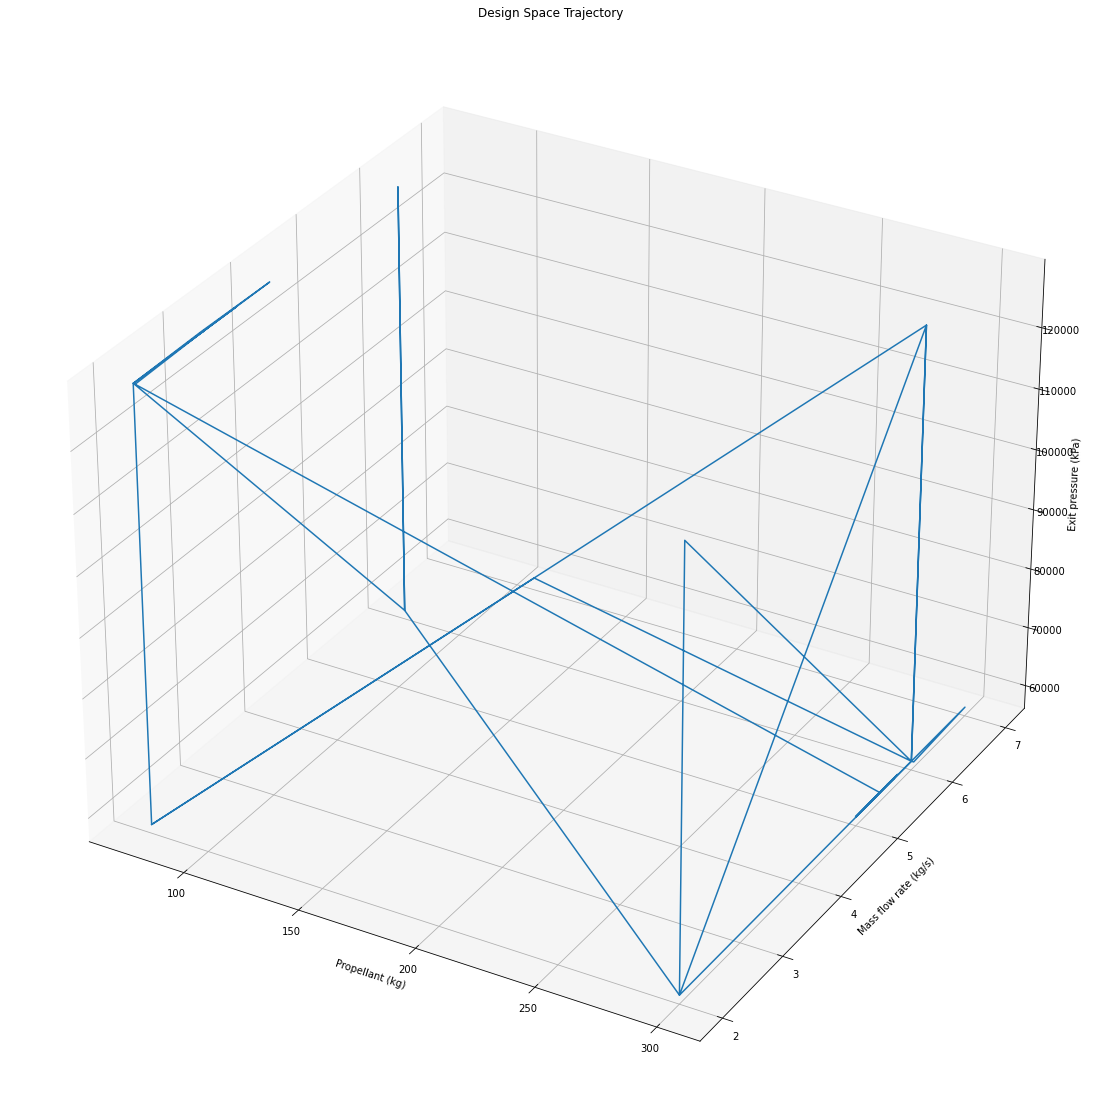

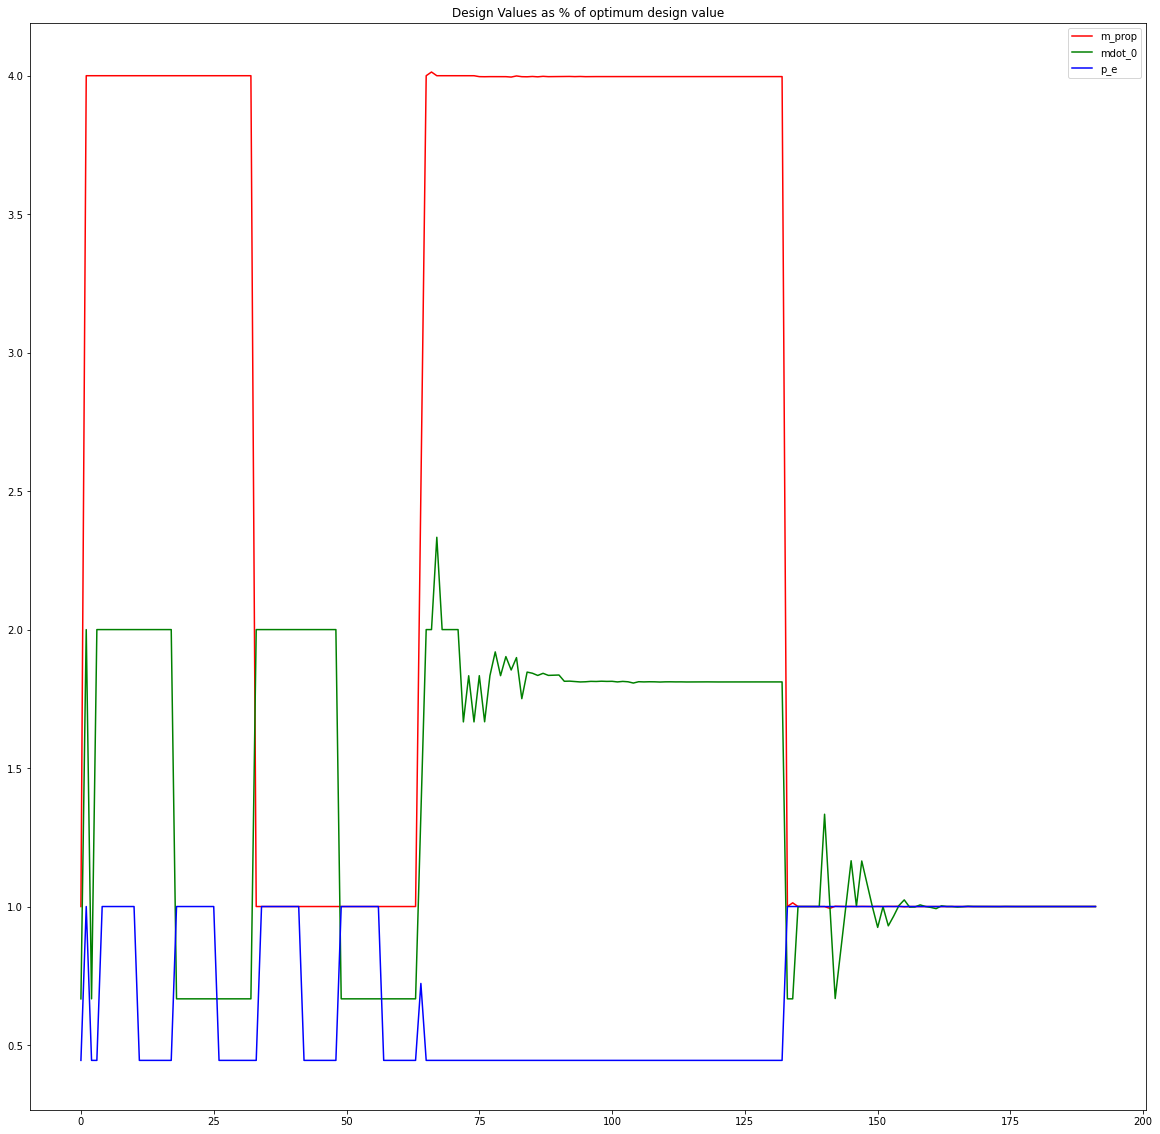

In [5]:
import os
import yaml

# Results, this is the big boi function
if __name__ == '__main__':
    
    # Get bonmin and ipopt paths from the path file
    path_file_dir = os.path.dirname(os.path.realpath("__file__"))
    path_file = open(os.path.join(path_file_dir, "bonmin_paths.yaml"))
    paths = yaml.safe_load(path_file)
    
    init_array = [M_PROP, MDOT, P_E, LOX_TANK_P, IPA_TANK_P, ENG_P_CH]
    print("Began optimization at", datetime.now())
    #np.seterr(all='raise')
    
    # RBFOpt
    '''
    bb = rbfopt.RbfoptUserBlackBox(len(init_array), 
                                   np.array([75, 1.5, 86346/4, 805000/2.5, 805000/2.5, 344738*1.5]), 
                                   np.array([375, 7, 86346*2.5, 2.068e6, 2.068e6, 4.137e6]), # design vector boundaries
                               np.array(['R']*len(init_array)), f)
    settings = rbfopt.RbfoptSettings(minlp_solver_path=paths["bonmin_path"],
                                     nlp_solver_path=paths["ipopt_path"],
                                    max_evaluations=800, eps_impr=1.0e-3)
    alg = rbfopt.RbfoptAlgorithm(settings, bb)
    val, x, itercount, evalcount, fast_evalcount = alg.optimize()
    '''
    
    # iterative nelder-mead
    # feed initial design into iterative optimizer, get most (locally) feasible design
    '''test = trajectory(init_array[0], init_array[1], init_array[2], 
               THROTTLE_WINDOW, MIN_THROTTLE,
               RCS_MDOT, RCS_P_E, RCS_P_CH, BALLAST, FIN_ROOT, FIN_TIP, FIN_SWEEP_ANGLE, FIN_SEMISPAN, FIN_THICKNESS, CON_NOSE_L,
               LOX_TANK_P, IPA_TANK_P, RIB_T, NUM_RADL_DVSNS,
               AIRFRM_IN_RAD, IPA_WT, OF, ENG_P_CH, ENG_T_CH, ENG_KE, ENG_MM,
               [0, 0, 0, 0, True, 0, 0, 0, 0, 0, 0, True], 
                          0.05, True, 0.045, False, False)
    
    if (test.alt[-1] < CONS_ALT) or (test.alt[-1] > CONS_CEILING): # rudimentary error handling to save heartache
        raise Exception('Rocket apogee out of bounds! Apogee {:.3f} km'.format(test.alt[-1]/1000))
    x = iterate(f, init_array, ITERATIONS)'''
    

    # probe design space, darwin style. takes forever, literally.
    #res = breed_rockets(f)
    
    # simplicial homology
    res = shgo(f, bounds=[*zip([75,2,86346/1.5, 805000/2,805000/2, 344738*1.5],
                                [300,6,86346*1.5,2.068e6, 2.068e6, 4.137e6])],   # design vector boundaries
                   n=100, iters=1, sampling_method='simplicial',
                    #minimizer_kwargs={'method':'SLSQP', 'options':{'disp': True,'maxiter':250}},
               minimizer_kwargs={'method':'COBYLA', 'options':{'disp': True, 'adaptive':True, 'maxfev':500, 'xatol': 0.01, 'fatol': 0.05}},
                  options={'disp':True})
    x = res.x
    xl = res.xl
    print('Global min:', x)
    print('Local min:', xl)
    print('Function values:', res.funl)
    
    
    print("Ended optimization at", datetime.now())
    print("Function evaluations:",len(allvectors))
    print("Optimization done!")
    
    ipa_wt, of_ratio, p_ch, Tc, MW, gamma, _ = propellant_optimizer(x[5])
    
    smaller_fin_sim = trajectory(False, 0, 0, 0, 0, 0, 0, 0, x[0], x[1], x[2],
               THROTTLE_WINDOW, MIN_THROTTLE,
               RCS_MDOT, RCS_P_E, RCS_P_CH,
               BALLAST, 0.762, 0.3302, 0.6981317007977318, 0.4064, 0.003175, CON_NOSE_L, #enter smaller fin parameters
                x[3], x[4], RIB_T, NUM_RADL_DVSNS,
               AIRFRM_IN_RAD, ipa_wt, of_ratio, x[5], Tc, gamma, MW,
               [0, 0, AZ_PERTURB, EL_PERTURB, True, 0, 0, 0, 0, 0, 0, True], 
                          0.025, False, 0.045, False, False)
    
    drop_time = find_drop_time(smaller_fin_sim.stability_margin)
    time_diff = []
    for item in smaller_fin_sim.t:
        time_diff.append(abs(item - drop_time))
    min_index = time_diff.index(min(time_diff))
    
    def altitude_to_ECEF(alt):
        return (alt + 6.371e3)
    
    drop_ECEF = altitude_to_ECEF(smaller_fin_sim.alt[min_index])
    print("Fin drop altitude: ", smaller_fin_sim.alt[min_index], "km")
    
    # get trajectory info from optimal design
    sim = trajectory(True, drop_ECEF, 0.762, 0.3302, 0.6981317007977318, 0.4064, 0.003175, 0, x[0], x[1], x[2],
               THROTTLE_WINDOW, MIN_THROTTLE,
               RCS_MDOT, RCS_P_E, RCS_P_CH,
               BALLAST, FIN_ROOT, FIN_TIP, FIN_SWEEP_ANGLE, FIN_SEMISPAN, FIN_THICKNESS, CON_NOSE_L,
                x[3], x[4], RIB_T, NUM_RADL_DVSNS,
               AIRFRM_IN_RAD, ipa_wt, of_ratio, x[5], Tc, gamma, MW,
               [0, 0, AZ_PERTURB, EL_PERTURB, True, 0, 0, 0, 0, 0, 0, True], 
                          0.025, False, 0.045, False, False)
    
    time_diff_2 = []
    for item in sim.t:
        time_diff_2.append(abs(item - drop_time))
    min_index_2 = time_diff_2.index(min(time_diff_2))
    print("Mach number upon fin dropping: ", sim.Ma[min_index_2])
    
    textlist = print_results(sim, True)
    # draw pretty pictures of optimized trajectory
    rocket_plot(sim.t, sim.alt, sim.v, sim.a, sim.thrust,
                sim.dyn_press, sim.Ma, sim.m, sim.p_a, sim.drag, sim.throttle, sim.fin_flutter, sim, True, None, None)
    # structural analysis
    structural_plot(sim.LV4)
    print(sim.env.ECEF_to_geodetic(sim.raw_states[-1][0][1]))
    print(sim.apogee)
    print(max([state[1][1][5][5] * 180 / np.pi
       for state in sim.raw_states[sim.LV4.tower_index:sim.LV4.F_index]]))
    print(sim.tip_off_aoa)
    # get/print info about our trajectory and rocket
    for line in textlist:
        print(line[1:])
    save_trajectory(sim)
    
    print('\nMaking an OpenRocket rocket and corresponding engine!')
    # create an openrocket file with matching engine for our design (and print/save trajectory data)
    make_engine(x[1], sim.m_prop, sim.thrust[0:sim.F_index + 1],
                sim.LV4.inr_r, AIRFRAME_THICKNESS, sim.LV4.l_o, sim.LV4.l_f, sim.LV4.m_tank_o, sim.LV4.m_tank_f,
                sim.t[sim.F_index], sim.LV4.engine.Ve/G_N,
                sim.LV4.eng_sys_dry_mass, sim.LV4.eng_sys_len, sim.openrocket_CoM,
                sim.LV4.ballast, sim.LV4.fin)
    
    # draw more pretty pictures, but of the optimizer guts
    design_grapher(allvectors)

## Mass breakdown: Propellant, Propulsion Modules, Pressurant (N2) and Airframe

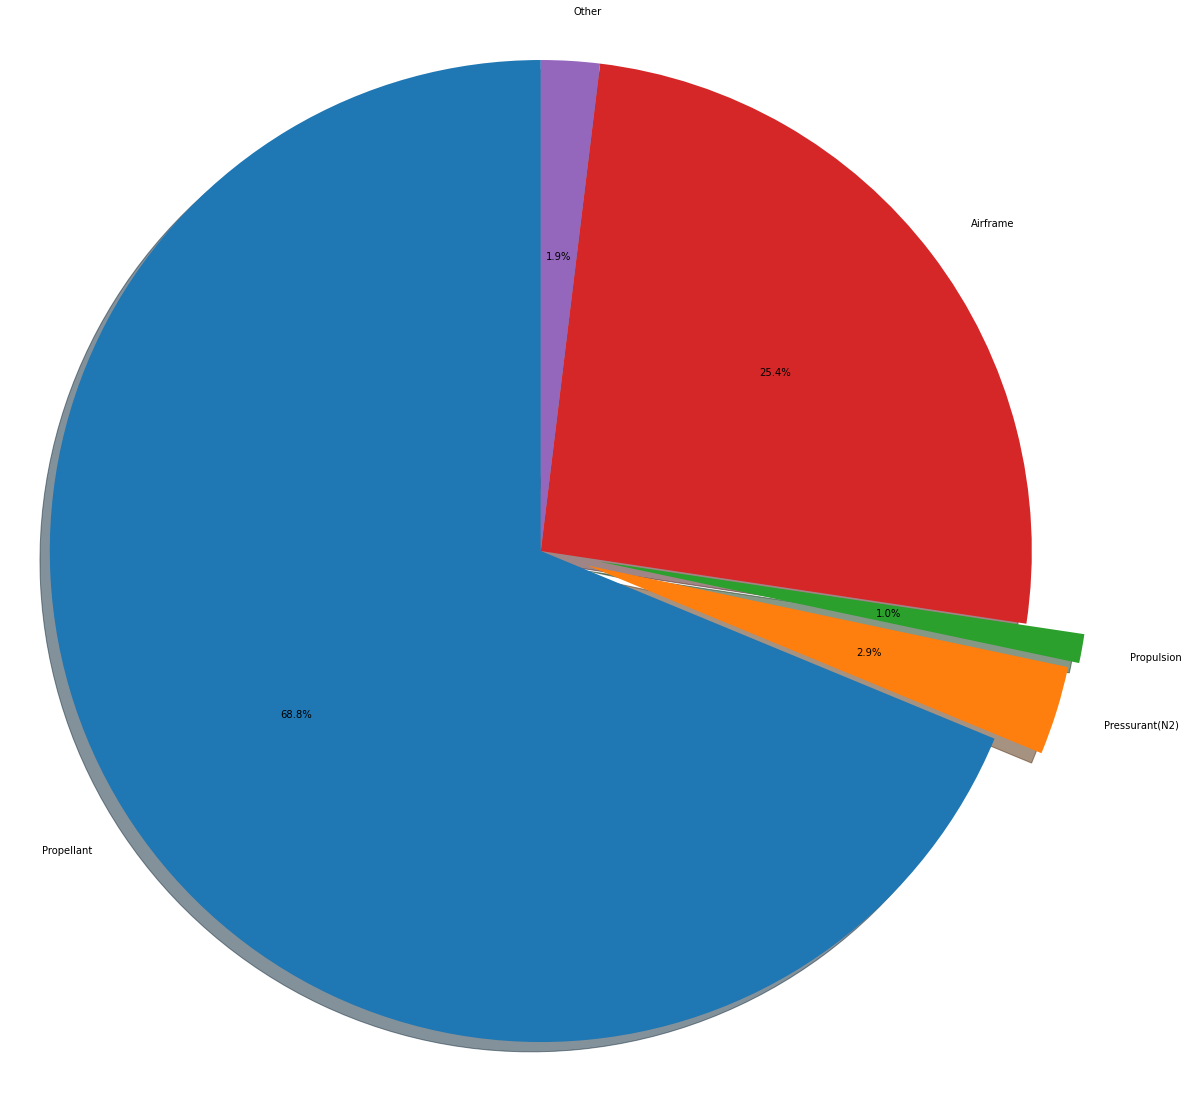

In [6]:
labels = 'Propellant', 'Pressurant(N2)', 'Propulsion', 'Airframe', 'Other'
propellant = sim.m_prop[0]
pressurant = sim.LV4.rcs_tank.gas_mass
propulsion = 4.24 # from post-flight mass budget
airfrm_diameter = sim.LV4.diameter
airfrm_length = sim.LV4.length
volume = ((np.pi * ((airfrm_diameter/2) ** 2) * airfrm_length)
          - (np.pi * (((airfrm_diameter/2) - AIRFRAME_THICKNESS) ** 2) * airfrm_length))
airframe = volume * 2700 # density of 6061-T6 aluminum in kg/m^3
total = sim.LV4.GLOW
other = total - (propellant + pressurant + propulsion + airframe)
sizes = [(propellant/total) * 100, (pressurant/total) * 100, (propulsion/total) * 100, (airframe/total) * 100, (other/total) * 100]
explode = (0, 0.1, 0.12, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Above, we can see the details of each iteration of the optimization sequence.

Then, we have detailed information from the trajectory of our optimal rocket design. Note that there are some low-level details suppressed here, but contained in the saved text file.

There is a plot of that trajectory and some of the state variables we care about, which can be enlightening.

Then there are three projections of the optimization path in the design space, as well as its 3D representation. This informs a sense of how an initial design is improved by the optimizer, and how design variables relate to each other.

The next visualization is of our design variables normalized as a percentage of their optimal values. This reduces the entire optimization into one easily comprehendable image. Note that spikes occur where iterations begin, since the Nelder-Mead method is reinitialized and must relearn how far it can move in any direction.

Finally, there is a semi-log plot of the merit values of our sequence of designs. The spikes are again from the beginning of iterations. If our problem is well-posed, punishment for deviation from feasibility will exponentially increase with each iteration and the minimum of each iteration will be decreasing. An ill-conditioned problem will have an increasing minimum with each iteration, since there would be no feasible design and the punishments would be growing. In either case, gaps appear in the plot where a design failed to satisfy the apogee window.

## Conclusion and Next Steps
*Prima facie*, this program produces viable rocket designs. The next step is to experiment with in OpenRocket with the model produced. It is critical that we make sure the stability requirement set by Base-11 is met (calibers > 2 throughout flight), and it is also an opportunity to experiment with different masses and fins, as well as environmental conditions such as wind or launching at 85 degrees.

Our sequence of merit evaluations is bounded below by 0 but is not bounded above, since some designs have infinite values. Provided that the problem is well-conditioned, the subsequence of minimums from each iteration is monotonically decreasing. So, it seems reasonable to infer that an ideal optimal rocket design exists for a well-posed problem. This program approximates that ideal design, but whether it is a good approximation might be a qualitative judgement.

There are other design and optimization methods, and different choices that could have been made. This code is fairly flexible so it isn't too difficult to change assumptions on the fly. The goal is not to provide a definitive final design of a rocket; rather it is to provide a design tool which will be useful throughout the design, manufacturing, and testing processes of LV4, up to and including the day it launches.

It is important to remember that the difference between design parameters and variables is largely stipulative. With slight effort, some parameters could be freed for optimization and some variables could be frozen. The chamber pressure has been stipulated and determines the thermodynamic properties that made us select the oxygen/fuel ratio we stipulate. There is another script in this repository that can be used to perform a trade-space analysis of chamber pressure and propellant configurations, if we decide to revisit those preliminary assumptions.

We have been conservative in our mass estimates in order to perform a more robust optimization. We could also take the maximum merit evaluation in the neighborborhood of a given design, as bounded by engineering tolerances, instead of simply evaluating a single design. That would obviously be computationally costly, but each neighborhood could be evaluated by parallel distributed processes, and the benefit of implementing a minmax problem instead of a minimization problem could be worth it, considering the inevitable inefficiencies that may arise in a physical system.

It would be a good idea to do some statistical analysis of the design space to produce a heat map as well, so we could characterize the topology of our design space. It's possible that there may be multiple optimal neighborhoods, and this would answer that question. Note that a sensitivity analysis of the current optimization program could also answer that question, by probing the design space with different initial designs.